# Project single-cell states onto the global cell state manifold

In this tutorial, we will use SCMG as a "Global Positioning System" to project single-cells onto the global map of cell states.

Let's begin by importing the required packages.

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc

import torch

from scmg.model.contrastive_embedding import CellEmbedder, embed_adata
from scmg.model.cell_type_search import CellTypeSearcher
from scmg.preprocessing.data_standardization import GeneNameMapper, standardize_adata

Load the trained SCMG model.

In [2]:
# Load the autoencoder model
model_path = 'models/embedder'

scmg_model = torch.load(os.path.join(model_path, 'model.pt'),
                        map_location=torch.device('cpu'))
scmg_model.load_state_dict(torch.load(os.path.join(model_path, 'best_state_dict.pth'),
                    map_location=torch.device('cpu')))

device = 'cpu'
scmg_model.to(device)
scmg_model.eval()

CellEmbedder(
  (encoder): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=18108, out_features=2048, bias=True)
      (1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.0, inplace=False)
      (4): Linear(in_features=2048, out_features=2048, bias=True)
      (5): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
      (6): LeakyReLU(negative_slope=0.01)
      (7): Dropout(p=0.0, inplace=False)
      (8): Linear(in_features=2048, out_features=512, bias=True)
    )
  )
  (decoder): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=576, out_features=1024, bias=True)
      (1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0, inplace=False)
      (4): Linear(in_features=1024, out_features=2048, bias=True)
      (5): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
      (6): LeakyReLU(negative_slope=0.01)
      

Load the example datasets

In [3]:
adata_ref = sc.read_h5ad('data/ref_global_cell_state_manifold.h5ad')
adata = sc.read('data/tutorial_data/Travaglini_Lung_HS_2021_10x_subsample.h5ad')
adata.var.index = adata.var['feature_id']

## Project a dataset of natural cell states

First, let's project a dataset that excluded from SCMG training to the representation dataset of the global cell state manifold.

In [4]:
# Embed the query dataset
embed_adata(scmg_model, adata, batch_size=8192)

# Project the query dataset to the reference dataset
cts = CellTypeSearcher(adata_ref)
cell_match_df = cts.search_ref_cell(adata.obsm['X_ce_latent'])
adata.obsm['X_project_umap'] = cell_match_df[['umap_x', 'umap_y']].values

  0%|          | 0/9 [00:00<?, ?it/s]

We can visualize the projected cells on the global cell state UMAP.

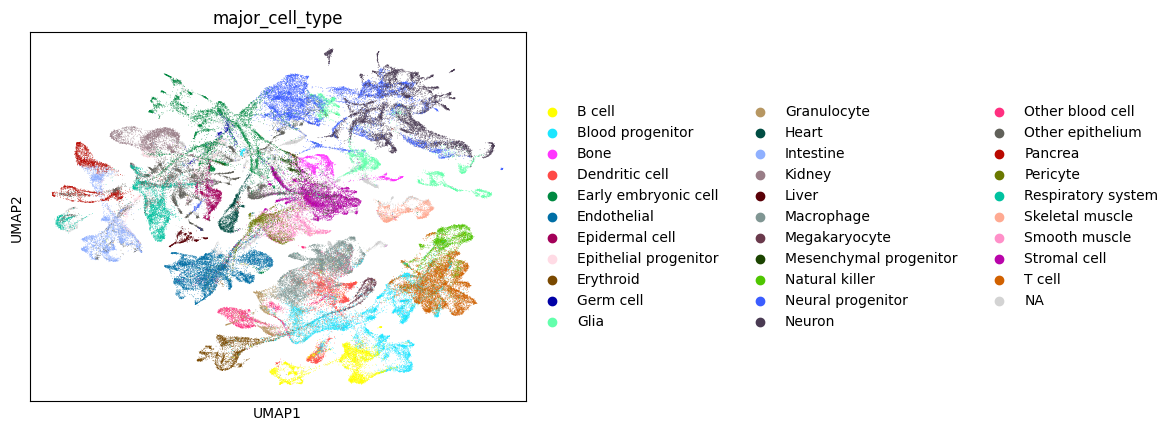

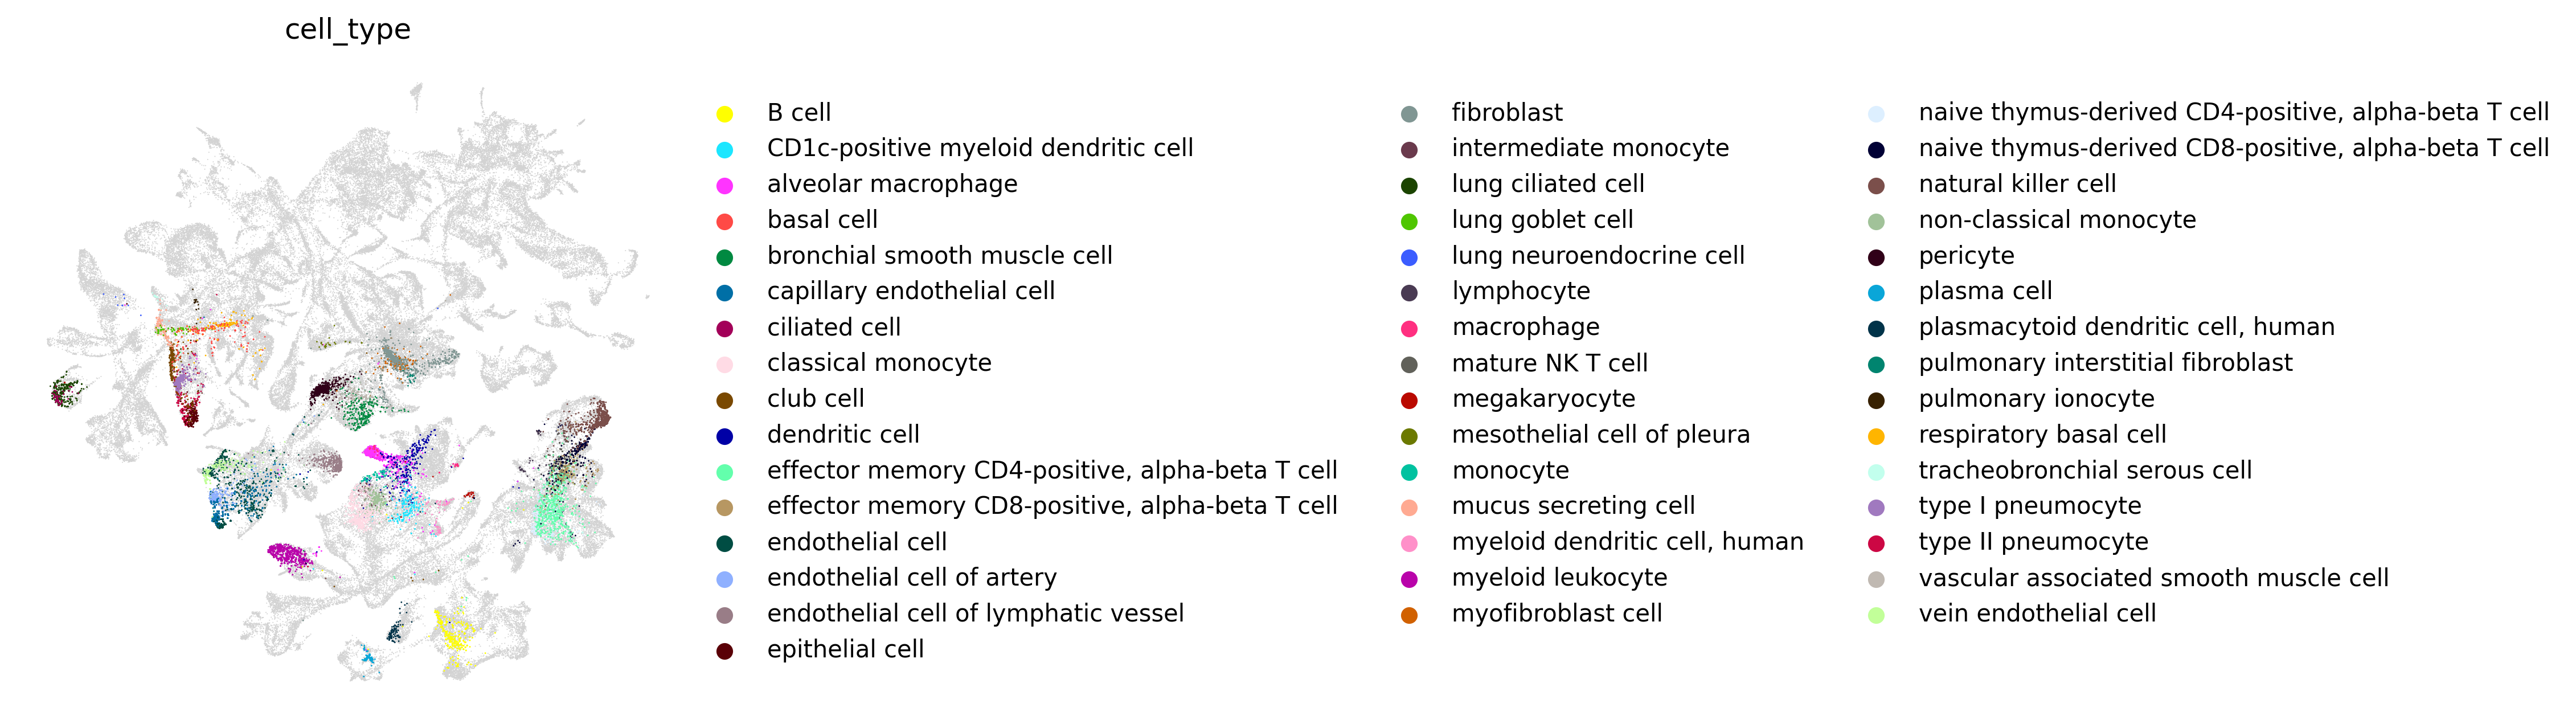

In [5]:
sc.pl.umap(adata_ref, color='major_cell_type')

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
sc.pl.umap(adata_ref, ax=ax, show=False)
sc.pl.embedding(adata, basis='X_project_umap', color='cell_type', ax=ax, frameon=False)
plt.show()

We can quantitatively compare the correspondence between the query cell types and the projected reference cell types.

In [6]:
adata.obs['ref_cell'] = cell_match_df['ref_cell'].values
adata.obs['projected_cell_type'] = adata_ref.obs['cell_type'].loc[
                                            cell_match_df['ref_cell']].values

ct_confusion_df = pd.crosstab(adata.obs['cell_type'], adata.obs['projected_cell_type'])
ct_confusion_df = ct_confusion_df / ct_confusion_df.values.sum(axis=1)[:, None]

for ct_query in ct_confusion_df.index:
    print(ct_confusion_df.loc[ct_query].sort_values(ascending=False).head(5))
    print()

projected_cell_type
B cell             0.613793
naive B cell       0.166897
plasma cell        0.064828
memory B cell      0.051034
immature B cell    0.027586
Name: B cell, dtype: float64

projected_cell_type
conventional dendritic cell             0.379699
dendritic cell                          0.274436
CD1c-positive myeloid dendritic cell    0.086466
Langerhans cell                         0.071429
macrophage                              0.048872
Name: CD1c-positive myeloid dendritic cell, dtype: float64

projected_cell_type
alveolar macrophage                   0.681553
alternatively activated macrophage    0.226958
elicited macrophage                   0.051649
macrophage                            0.023415
dendritic cell                        0.005837
Name: alveolar macrophage, dtype: float64

projected_cell_type
club cell                  0.201923
respiratory basal cell     0.147436
respiratory goblet cell    0.144231
lung secretory cell        0.083333
basal cell             

Let's plot the correspondence between the query cell types and the top matched reference cell types as a confusion matrix.

<Axes: xlabel='cell_type', ylabel='projected_cell_type'>

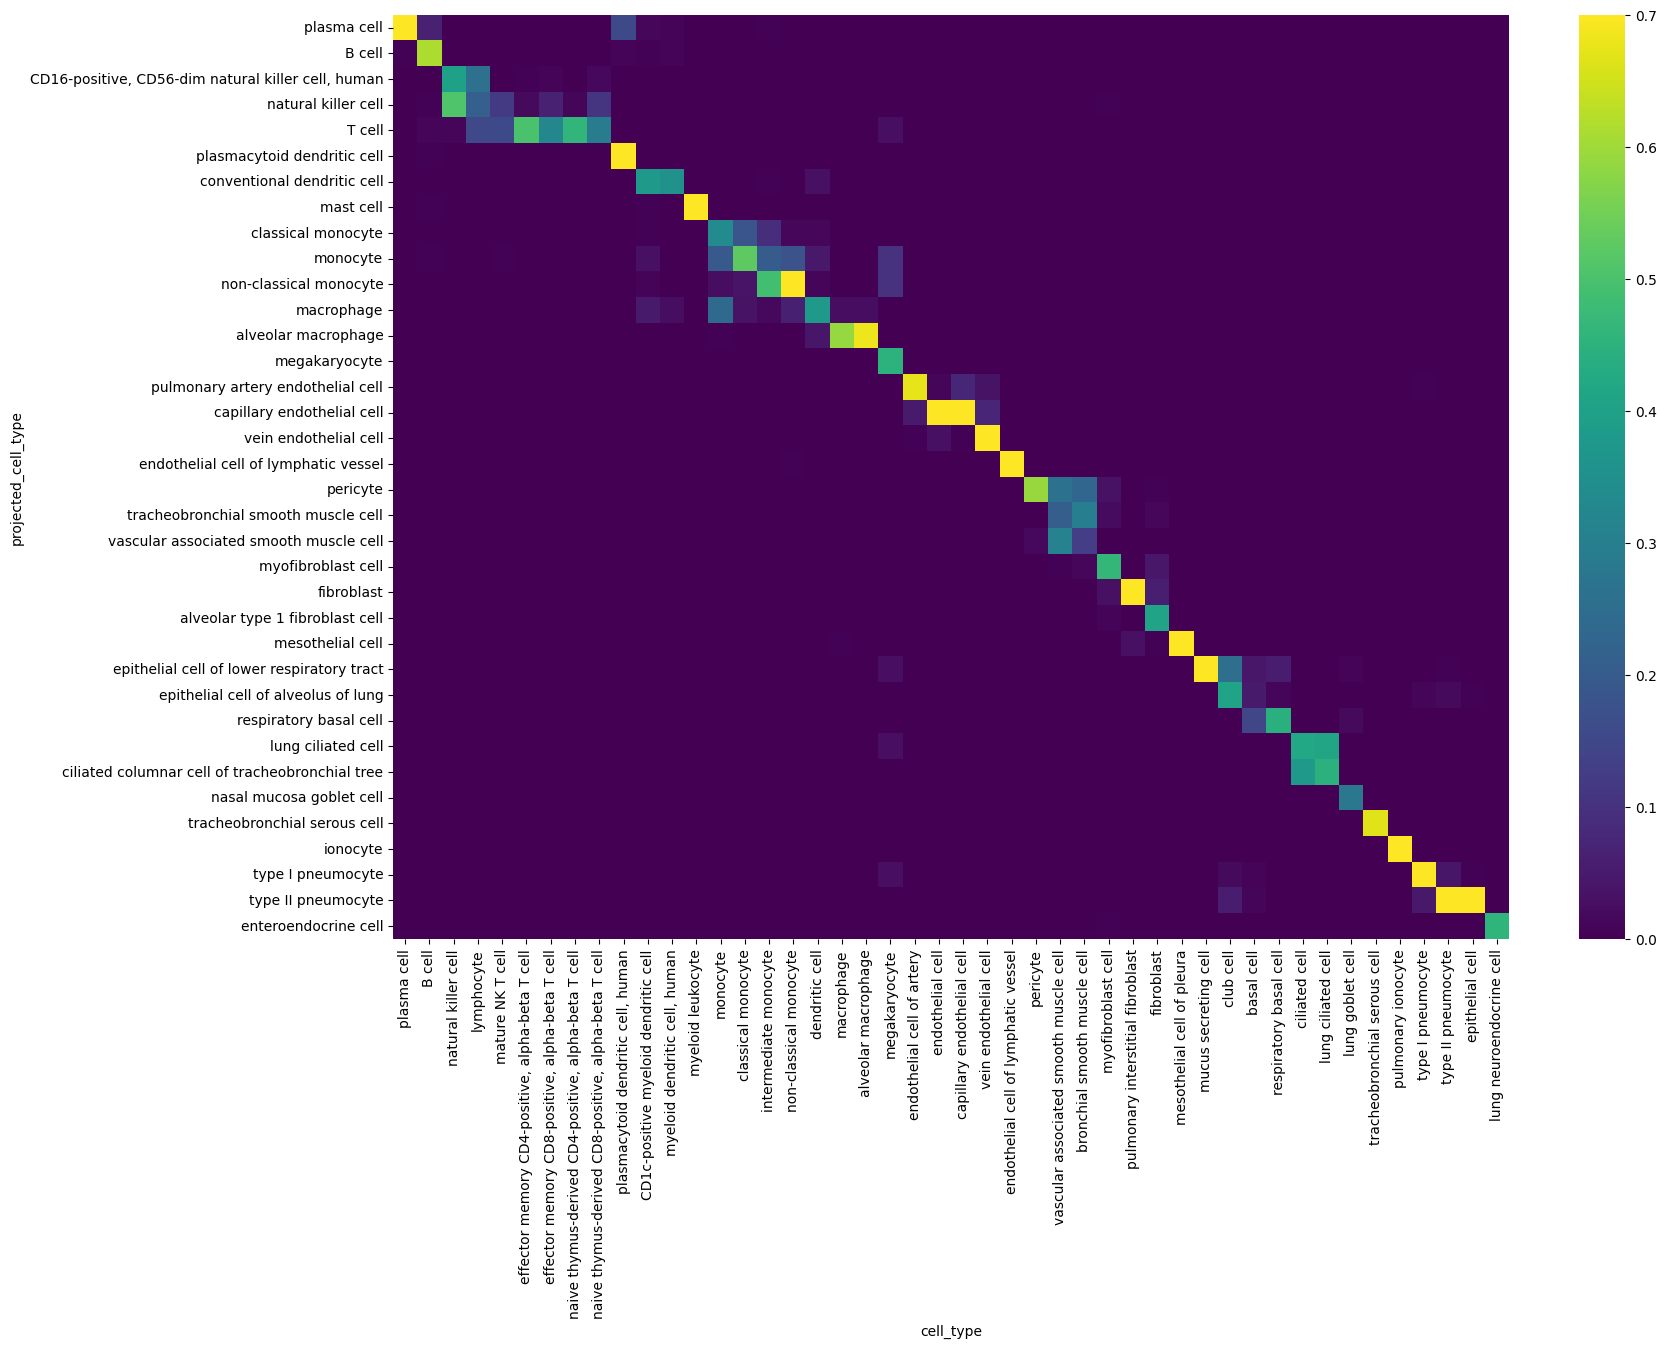

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(18, 12))


sns.heatmap(ct_confusion_df.loc[
    [
    'plasma cell',
    'B cell', 
    'natural killer cell',
    'lymphocyte',
    'mature NK T cell',
    'effector memory CD4-positive, alpha-beta T cell',
    'effector memory CD8-positive, alpha-beta T cell',
    'naive thymus-derived CD4-positive, alpha-beta T cell',
    'naive thymus-derived CD8-positive, alpha-beta T cell',
    'plasmacytoid dendritic cell, human',
    'CD1c-positive myeloid dendritic cell',
    'myeloid dendritic cell, human',
    'myeloid leukocyte',
    'monocyte',
    'classical monocyte',
    'intermediate monocyte',
    'non-classical monocyte',
    'dendritic cell',
    'macrophage',
    'alveolar macrophage',
    'megakaryocyte',
    'endothelial cell of artery',
    'endothelial cell',
    'capillary endothelial cell',
    'vein endothelial cell',
    'endothelial cell of lymphatic vessel',
    'pericyte',
    'vascular associated smooth muscle cell',
    'bronchial smooth muscle cell',
    'myofibroblast cell',
    'pulmonary interstitial fibroblast',
    'fibroblast',
    'mesothelial cell of pleura',
    'mucus secreting cell',
    'club cell',
    'basal cell',
    'respiratory basal cell',
    'ciliated cell',
    'lung ciliated cell',
    'lung goblet cell',
    'tracheobronchial serous cell',
    'pulmonary ionocyte',
    'type I pneumocyte',
    'type II pneumocyte',
    'epithelial cell',
    'lung neuroendocrine cell',
    ], 
    [
    'plasma cell',
    'B cell', 
    'CD16-positive, CD56-dim natural killer cell, human',
    'natural killer cell',
    'T cell',
    'plasmacytoid dendritic cell',
    'conventional dendritic cell',
    'mast cell',
    'classical monocyte',
    'monocyte',
    'non-classical monocyte',
    'macrophage',
    'alveolar macrophage',
    'megakaryocyte',
    'pulmonary artery endothelial cell',
    'capillary endothelial cell',
    'vein endothelial cell',
    'endothelial cell of lymphatic vessel',
    'pericyte',
    'tracheobronchial smooth muscle cell',
    'vascular associated smooth muscle cell',
    'myofibroblast cell',
    'fibroblast',
    'alveolar type 1 fibroblast cell',
    'mesothelial cell',
    'epithelial cell of lower respiratory tract',
    'epithelial cell of alveolus of lung',
    'respiratory basal cell',
    'lung ciliated cell',
    'ciliated columnar cell of tracheobronchial tree',
    'nasal mucosa goblet cell',
    'tracheobronchial serous cell',
    'ionocyte',
    'type I pneumocyte',
    'type II pneumocyte',
    'enteroendocrine cell',   
    ]].T,
    cmap='viridis', vmax=0.7)


The confusion matrix shows that the query cells are correctly projected to the corresponding cell types in the global cell state manifold.

## Project a dataset of transdifferentiation

Projecting single-cells onto the global cell state manifold can be useful for interpreting non-natural cell states generated in the lab.

As an example, let's project cells from a transdifferentiation experiment.

  0%|          | 0/1 [00:00<?, ?it/s]

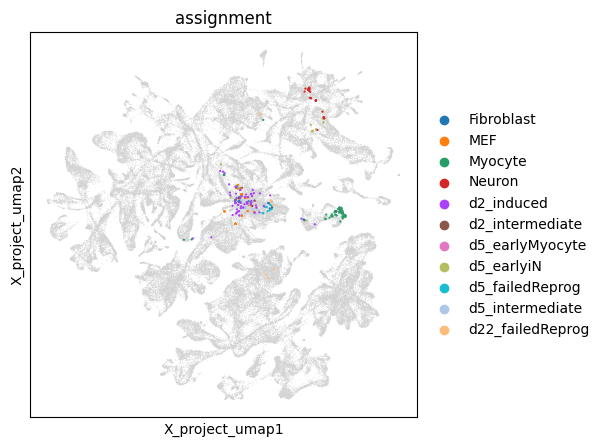

<Axes: xlabel='projected_cell_type', ylabel='assignment'>

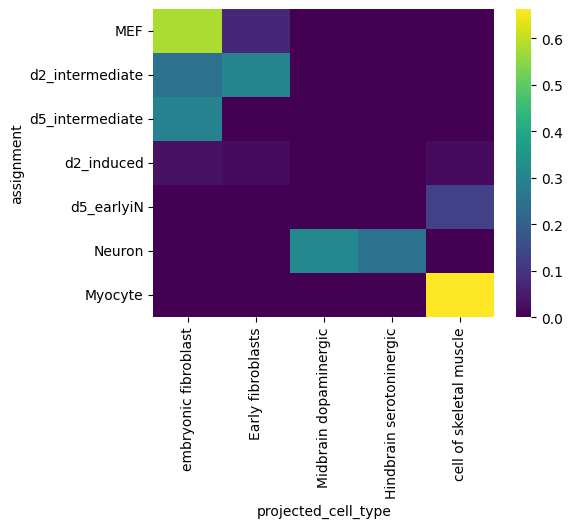

In [8]:
# Load the data
adata = sc.read_h5ad(
    'data/tutorial_data/Treutlein_2016_neuron_transdifferentiation.h5ad')

adata.obs_names_make_unique()
gene_name_mapper = GeneNameMapper()
adata.var.index = gene_name_mapper.map_gene_names(adata.var.index,
                            'mouse', 'human', 'name', 'id')
adata = adata[:, adata.var.index != 'na'].copy()
adata.var_names_make_unique()

# Embed the query dataset
embed_adata(scmg_model, adata, batch_size=4096)

# Project the query dataset to the reference dataset
cts = CellTypeSearcher(adata_ref)
cell_match_df = cts.search_ref_cell(adata.obsm['X_ce_latent'])
adata.obsm['X_project_umap'] = cell_match_df[['umap_x', 'umap_y']].values

# Visualize the UMAP projection
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)
sc.pl.umap(adata_ref, ax=ax, show=False)
sc.pl.embedding(adata, 
                basis='X_project_umap', color='assignment', 
                ax=ax, s=10)
plt.show()

# Plot the confusion matrix
adata.obs['projected_cell_type'] = adata_ref.obs['cell_type'].loc[
                                            cell_match_df['ref_cell']].values
ct_confusion_df = pd.crosstab(adata.obs['assignment'], adata.obs['projected_cell_type'])
ct_confusion_df = ct_confusion_df / ct_confusion_df.values.sum(axis=1)[:, None]

fig, ax = plt.subplots(1, 1, figsize=(5.5, 4), dpi=100)

sns.heatmap(ct_confusion_df.loc[
    [
        'MEF',
        'd2_intermediate',
        'd5_intermediate',
        'd2_induced',
        'd5_earlyiN',
        'Neuron',
        'Myocyte',

     ], 
    [
        'embryonic fibroblast',
        'Early fibroblasts',
        'Midbrain dopaminergic',
        'Hindbrain serotoninergic',
        'cell of skeletal muscle',

     ]],
    cmap='viridis')

We can see that the transdifferentiated neurons and myocytes are projected to some physiological cell types of neurons and muscles.

What are the genes that agree or disagree with such projection? Let's use myocytes as an example to compare the gene expression profiles of the query cell state and the projected cell state.

Double positive genes:


/home/xingjie/Softwares/SCMG/scmg/preprocessing/data_standardization.py:158: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_standard = anndata.AnnData(


array(['TNNC2', 'MYL11', 'MYL1', 'TNNT3'], dtype=object)

Query positive, ref negative genes:


array(['ASCL1', 'GPC1', 'KRT33A', 'PRUNE2'], dtype=object)

Query negative, ref positive genes:


array(['MYOZ1', 'ATP2A1', 'MYBPC2', 'ACTN3'], dtype=object)

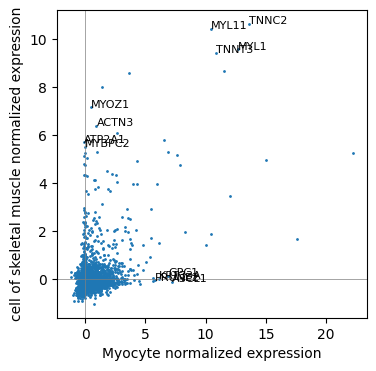

In [9]:
# Normalize the reference dataset gene expression
sc.pp.normalize_total(adata_ref, target_sum=1e4)
sc.pp.log1p(adata_ref)
adata_ref.var['mean'] = np.array(adata_ref.X.mean(axis=0)).flatten()
X_csc = adata_ref.X.tocsc()
adata_ref.var['std'] = [np.std(X_csc.getcol(i).toarray()) for i in range(adata_ref.X.shape[1])]

# Get the cell types to compare
query_ct = 'Myocyte'
projected_ct = 'cell of skeletal muscle'
adata_selected_query = standardize_adata(adata[
    (adata.obs['assignment'] == query_ct) & (adata.obs['projected_cell_type'] == projected_ct)
].copy())

# Normalize the query dataset gene expression
sc.pp.normalize_total(adata_selected_query, target_sum=1e4)
sc.pp.log1p(adata_selected_query)

adata_selected_ref = adata_ref[
    adata_ref.obs['cell_type'] == projected_ct
].copy()

# Compare the mean gene expression in the query and reference cell types
x_query = adata_selected_query.X.mean(axis=0) - adata_selected_ref.var['mean']
x_query = x_query / np.maximum(adata_selected_ref.var['std'], 0.1)
x_ref = np.array(adata_selected_ref.X.mean(axis=0)).flatten() - adata_selected_ref.var['mean']
x_ref = x_ref / np.maximum(adata_selected_ref.var['std'], 0.1)

comp_df = pd.DataFrame({
    'gene': list(adata_selected_ref.var['human_gene_name']),
    'x_query': x_query,
    'x_ref': x_ref,
}).set_index('gene')

comp_df['x_diff'] = comp_df['x_query'] - comp_df['x_ref']

# Only keep the genes measured in the query dataset
comp_df = comp_df[comp_df.index.isin(
    gene_name_mapper.map_gene_names(adata.var.index, 'human', 'human', 'id', 'name'))].copy()

# Find the matched and unmatched genes
double_pos_genes = comp_df[(comp_df['x_query'] > 2) & (comp_df['x_ref'] > 2)
                           ].sort_values('x_ref', ascending=False)[:4].index.values

q_pos_r_neg_genes = comp_df[(comp_df['x_query'] > 3) & (comp_df['x_ref'] < 1)
                           ].sort_values('x_diff', ascending=False)[:4].index.values

q_neg_r_pos_genes = comp_df[(comp_df['x_query'] < 1) & (comp_df['x_ref'] > 3)
                            ].sort_values('x_diff', ascending=True)[:4].index.values

print('Double positive genes:')
display(double_pos_genes)
print('Query positive, ref negative genes:')
display(q_pos_r_neg_genes)
print('Query negative, ref positive genes:')
display(q_neg_r_pos_genes)

# Plot the gene expression comparison
fig, ax = plt.subplots(figsize=(4, 4), dpi=100)

ax.scatter(comp_df['x_query'], comp_df['x_ref'], s=1, rasterized=True)

comp_df_to_show = comp_df[comp_df.index.isin(
    np.concatenate([double_pos_genes, q_pos_r_neg_genes, q_neg_r_pos_genes]))]

for i, row in comp_df_to_show.iterrows():
    ax.text(row['x_query'], row['x_ref'], i, fontsize=8)

ax.axhline(c='grey', lw=0.5)
ax.axvline(c='grey', lw=0.5)
ax.set_xlabel(query_ct + ' normalized expression', fontsize=10)
ax.set_ylabel(projected_ct +  ' normalized expression', fontsize=10)

plt.show()

While the transdifferentiated muscle cells expressed MYL1 and TNNC2, they did not express genes such as MYOZ1, which might cause the induced muscle cells to function differently than the normal muscle cells.

We can plot the global gene expression pattern of MYOZ1 to see that it is indeed a marker gene of skeletal muscle cells.

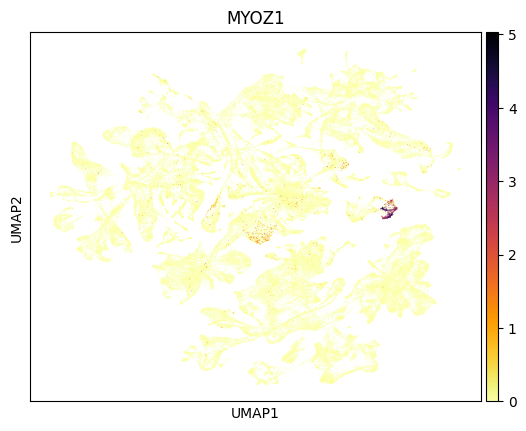

In [10]:
adata_ref.var.index = adata_ref.var['human_gene_name']
sc.pl.umap(adata_ref, color=['MYOZ1'],
           cmap='inferno_r')